In [140]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy import CacheHandler, SpotifyOAuth, Spotify
import spotipy.util as util
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from sklearn.feature_selection import SelectKBest, f_regression

In [3]:
cid = ''
secret = ''
redirect_uri = ''
os.environ['SPOTIPY_CLIENT_ID'] = cid
os.environ['SPOTIPY_CLIENT_SECRET'] = secret
os.environ['SPOTIPY_REDIRECT_URI'] = redirect_uri

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
spotify = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

username = ''
scope = 'user-top-read'

auth = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

### Build/import datasets:
- User most streamed tracks (2018 - 2023)
    - Spotify API "Get User's Top Items": top 600 tracks overall for past 6 months
    - Create a dataset out of Spotify Wrapped tracks

In [4]:
# Retrieve user top items
user_top_items = auth.current_user_top_tracks(time_range='medium_term',limit=50,offset=0)

user_track_ids = []
user_tracks = []

user_top_tracks = user_top_items['items']

while user_top_items['next']:
    user_top_items = spotify.next(user_top_items)
    user_top_tracks.extend(user_top_items['items'])
user_top_tracks

# Create arrays with all track IDs, track names, artists
for track in user_top_tracks:
    user_track_ids.append(track['id'])
    user_tracks.append([track['id'], track['name'], track['artists'][0]['name']])

In [5]:
# Retrieve Spotify Wrapped
personal_tracks_import = spotify.playlist_tracks(playlist_id='https://open.spotify.com/playlist/XXXX')

personal_track_ids = []
personal_tracks = []

all_personal_import = personal_tracks_import['items']

while personal_tracks_import['next']:
    personal_tracks_import = spotify.next(personal_tracks_import)
    all_personal_import.extend(personal_tracks_import['items'])

# Create arrays with all track IDs, track names, artists
year = 2018
count = 0
for track in all_personal_import:
    if count == 100:
        count = 0
        year += 1
    personal_track_ids.append(track['track']['id'])
    personal_tracks.append([track['track']['id'], track['track']['name'], track['track']['artists'][0]['name'], year])
    count += 1

- Spotify most streamed tracks (2018 - 2023)
- Dataset links:
    - 2018: https://www.kaggle.com/datasets/nadintamer/top-spotify-tracks-of-2018
    - 2019: https://www.kaggle.com/datasets/nadintamer/top-spotify-tracks-of-2019
    - (import from spotify) 2020: https://open.spotify.com/playlist/37i9dQZF1DX7Jl5KP2eZaS?si=65c6d71733704f79
    - 2021: https://www.kaggle.com/datasets/equinxx/spotify-top-50-songs-in-2021/data
    - (import from spotify) 2022: https://open.spotify.com/playlist/56r5qRUv3jSxADdmBkhcz7?si=d19646e8012f495f
    - 2023: https://www.kaggle.com/datasets/yukawithdata/spotify-top-tracks-2023?resource=download&select=top_50_2023.csv


In [6]:
top2018 = pd.read_csv('/Users/tiffanychen/Desktop/uni/spotify_song_analysis/topsongs2018.csv')
top2019 = pd.read_csv('/Users/tiffanychen/Desktop/uni/spotify_song_analysis/topsongs2019.csv')
top2021 = pd.read_csv('/Users/tiffanychen/Desktop/uni/spotify_song_analysis/topsongs2021.csv')
top2023 = pd.read_csv('/Users/tiffanychen/Desktop/uni/spotify_song_analysis/topsongs2023.csv')

top2020_import = spotify.playlist_tracks(playlist_id='https://open.spotify.com/playlist/XXXX')
top2022_import = spotify.playlist_tracks(playlist_id='https://open.spotify.com/playlist/XXXX')

top2020 = []
top2022 = []

top2020_ids = []
top2022_ids = []

# Create arrays with all track IDs and track names
for item in top2020_import['items']:
    top2020_ids.append(item['track']['id'])
    top2020.append([item['track']['id'], item['track']['name'], item['track']['artists'][0]['name']])

for item in top2022_import['items']:
    top2022_ids.append(item['track']['id'])
    top2022.append([item['track']['id'], item['track']['name'], item['track']['artists'][0]['name']])


### Clean datasets:
- Retrieve audio features for user top tracks using user_track_ids

In [7]:
user_track_df = pd.DataFrame(columns = ['track_id', 'name', 'artists', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature'])

get = spotify.audio_features(user_track_ids[0:100])
get2 = spotify.audio_features(user_track_ids[100:200])

get3 = spotify.audio_features(user_track_ids[200:300])
get4 = spotify.audio_features(user_track_ids[300:400])

get5 = spotify.audio_features(user_track_ids[400:500])
get6 = spotify.audio_features(user_track_ids[500:600])

features = [get, get2, get3, get4, get5, get6]

In [8]:
count = 0
for i in range(0,6):
    for j in range(0, 100):
        curr_features = features[i][j]
        curr_row = {'track_id':curr_features['id'], 
                        'name':user_tracks[count][1],
                        'artists':user_tracks[count][2],
                        'danceability':curr_features['danceability'],
                        'energy':curr_features['energy'],
                        'key':curr_features['key'],
                        'loudness':curr_features['loudness'],
                        'mode':curr_features['mode'],
                        'speechiness':curr_features['speechiness'],
                        'acousticness':curr_features['acousticness'],
                        'instrumentalness':curr_features['instrumentalness'],
                        'liveness':curr_features['liveness'],
                        'valence':curr_features['valence'],
                        'tempo':curr_features['tempo'],
                        'duration_ms':curr_features['duration_ms'],
                        'time_signature':curr_features['time_signature']
                        }
        user_track_df = pd.concat([user_track_df, pd.DataFrame([curr_row])], ignore_index=True)
        count += 1
user_track_df

/var/folders/k9/dtt754b102l_98gz5tx8nsqr0000gn/T/ipykernel_27793/2804139229.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  user_track_df = pd.concat([user_track_df, pd.DataFrame([curr_row])], ignore_index=True)


,track_id,name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,136oL23K6A6g4PvptBWcS7,"Youth (YUNHO, MINGI)",ATEEZ,0.555,0.594,5,-5.343,0,0.1090,0.02870,0,0.2470,0.529,169.966,209360,4
1,2wj2Mh7Zmp036eH1aY6nAW,Turbulence,ATEEZ,0.462,0.826,4,-5.584,1,0.0718,0.10700,0,0.1790,0.615,169.980,199586,4
2,0fmdJr4UEfmqFCGFswAJPe,Not Too Late,ATEEZ,0.684,0.475,8,-7.646,1,0.0350,0.30800,0.000006,0.1510,0.495,94.039,214104,4
3,52PCrf2tqml44bWLNT58hF,MIST,ATEEZ,0.565,0.831,8,-2.758,1,0.0374,0.08180,0,0.1300,0.361,127.992,199027,4
4,7hWW1JxF5ArjPgAsGlwSuz,Silver Light,ATEEZ,0.695,0.828,2,-5.329,1,0.0506,0.01760,0.000001,0.0953,0.363,100.003,230477,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,40rSlnWWx2p4r9lLOwNn96,Memories Fade,Kupla,0.390,0.477,9,-6.945,0,0.1700,0.86100,0.0945,0.5010,0.242,79.910,147475,4
596,40zS3lIDdWARWhT2BX1oTl,snowfall,oofoe,0.498,0.353,6,-11.109,1,0.0620,0.88500,0.916,0.1120,0.791,151.556,89976,4
597,47oFVn0fGUsdUcK5coajGW,Alone Time,Purrple Cat,0.645,0.243,7,-16.029,1,0.0306,0.87400,0.864,0.1360,0.483,135.869,202996,4
598,4BDowMGFUrOgAUQYrxBWKy,I Will Show You,周震南,0.444,0.845,3,-4.859,0,0.1110,0.00748,0.141,0.1150,0.445,77.058,203906,4


- Retrieve audio features for Spotify Wrapped using personal_track_ids

In [9]:
wrapped_df = pd.DataFrame(columns = ['track_id', 'year','name', 'artists', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature'])

get = spotify.audio_features(personal_track_ids[0:100])
get2 = spotify.audio_features(personal_track_ids[100:200])

get3 = spotify.audio_features(personal_track_ids[200:300])
get4 = spotify.audio_features(personal_track_ids[300:400])

get5 = spotify.audio_features(personal_track_ids[400:500])
get6 = spotify.audio_features(personal_track_ids[500:600])

In [10]:
features = [get, get2, get3, get4, get5, get6]

In [11]:
count = 0
for i in range(0,6):
    for j in range(0, 100):
        curr_features = features[i][j]
        curr_row = {'track_id':curr_features['id'], 
                        'year':personal_tracks[count][3],
                        'name':personal_tracks[count][1],
                        'artists':personal_tracks[count][2],
                        'danceability':curr_features['danceability'],
                        'energy':curr_features['energy'],
                        'key':curr_features['key'],
                        'loudness':curr_features['loudness'],
                        'mode':curr_features['mode'],
                        'speechiness':curr_features['speechiness'],
                        'acousticness':curr_features['acousticness'],
                        'instrumentalness':curr_features['instrumentalness'],
                        'liveness':curr_features['liveness'],
                        'valence':curr_features['valence'],
                        'tempo':curr_features['tempo'],
                        'duration_ms':curr_features['duration_ms'],
                        'time_signature':curr_features['time_signature']
                        }
        wrapped_df = pd.concat([wrapped_df, pd.DataFrame([curr_row])], ignore_index=True)
        count += 1

/var/folders/k9/dtt754b102l_98gz5tx8nsqr0000gn/T/ipykernel_27793/3157329444.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  wrapped_df = pd.concat([wrapped_df, pd.DataFrame([curr_row])], ignore_index=True)


- Retrieve audio features for top2020, top2022 data

In [12]:
top2020_df = pd.DataFrame(columns = ['track_id', 'name', 'artists', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature'])

get = spotify.audio_features(top2020_ids[0:101])

In [13]:
count = 0
for curr_features in get:
    #get = spotify.audio_features(track[0])
    #curr_features = get[0]
    curr_row = {'track_id':curr_features['id'],
                       'name':top2020[count][1],
                       'artists':top2020[count][2],
                       'danceability':curr_features['danceability'],
                       'energy':curr_features['energy'],
                       'key':curr_features['key'],
                       'loudness':curr_features['loudness'],
                       'mode':curr_features['mode'],
                       'speechiness':curr_features['speechiness'],
                       'acousticness':curr_features['acousticness'],
                       'instrumentalness':curr_features['instrumentalness'],
                       'liveness':curr_features['liveness'],
                       'valence':curr_features['valence'],
                       'tempo':curr_features['tempo'],
                       'duration_ms':curr_features['duration_ms'],
                       'time_signature':curr_features['time_signature']
                       }
    top2020_df = pd.concat([top2020_df, pd.DataFrame([curr_row])], ignore_index=True)
    count += 1

/var/folders/k9/dtt754b102l_98gz5tx8nsqr0000gn/T/ipykernel_27793/3313089355.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  top2020_df = pd.concat([top2020_df, pd.DataFrame([curr_row])], ignore_index=True)


In [14]:
top2022_df = pd.DataFrame(columns = ['track_id', 'name', 'artists', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature'])

get = spotify.audio_features(top2022_ids[0:101])

In [15]:
count = 0
for curr_features in get:
    curr_row = {'track_id':curr_features['id'],
                       'name':top2022[count][1],
                       'artists':top2022[count][2],
                       'danceability':curr_features['danceability'],
                       'energy':curr_features['energy'],
                       'key':curr_features['key'],
                       'loudness':curr_features['loudness'],
                       'mode':curr_features['mode'],
                       'speechiness':curr_features['speechiness'],
                       'acousticness':curr_features['acousticness'],
                       'instrumentalness':curr_features['instrumentalness'],
                       'liveness':curr_features['liveness'],
                       'valence':curr_features['valence'],
                       'tempo':curr_features['tempo'],
                       'duration_ms':curr_features['duration_ms'],
                       'time_signature':curr_features['time_signature']
                       }
    top2022_df = pd.concat([top2022_df, pd.DataFrame([curr_row])], ignore_index=True)
    count += 1

/var/folders/k9/dtt754b102l_98gz5tx8nsqr0000gn/T/ipykernel_27793/790588760.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  top2022_df = pd.concat([top2022_df, pd.DataFrame([curr_row])], ignore_index=True)


- Merge all top20xx datasets into one dataframe

In [16]:
# Rearrange columns for top2021, top2023 to match the rest
print(top2018.columns.tolist())
print(top2021.columns.tolist())
print(top2023.columns.tolist())

['id', 'name', 'artists', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']
['id', 'artist_name', 'track_name', 'track_id', 'popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']
['artist_name', 'track_name', 'is_explicit', 'album_release_date', 'genres', 'danceability', 'valence', 'energy', 'loudness', 'acousticness', 'instrumentalness', 'liveness', 'speechiness', 'key', 'tempo', 'mode', 'duration_ms', 'time_signature', 'popularity']


In [17]:
# Rename columns for consistency
top2021 = top2021.rename({'artist_name': 'artists', 'track_name': 'name', 'id': 'index', 'track_id': 'id'}, axis=1)
top2023['id'] = 'NA'
top2023 = top2023.rename({'artist_name': 'artists', 'track_name': 'name'}, axis=1)
print(top2021.columns.tolist())
print(top2023.columns.tolist())

['index', 'artists', 'name', 'id', 'popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']
['artists', 'name', 'is_explicit', 'album_release_date', 'genres', 'danceability', 'valence', 'energy', 'loudness', 'acousticness', 'instrumentalness', 'liveness', 'speechiness', 'key', 'tempo', 'mode', 'duration_ms', 'time_signature', 'popularity', 'id']


In [18]:
# Rearrange
top2021 = top2021[['id', 'name', 'artists', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']]
top2023 = top2023[['id', 'name', 'artists', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']]
print(top2021.columns.tolist())
print(top2023.columns.tolist())

['id', 'name', 'artists', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']
['id', 'name', 'artists', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']


In [19]:
# Track the year on each dataset
top2018['year'] = 2018
top2019['year'] = 2019
top2020_df['year'] = 2020
top2021['year'] = 2021
top2022_df['year'] = 2022
top2023['year'] = 2023

In [20]:
global_trends = pd.DataFrame(columns = ['track_id', 'name', 'artists', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'year'])
global_trends = pd.concat([top2018, top2019], axis=0)
global_trends = pd.concat([global_trends, top2020_df], axis=0)
global_trends = pd.concat([global_trends, top2021], axis=0)
global_trends = pd.concat([global_trends, top2022_df], axis=0)
global_trends = pd.concat([global_trends, top2023], axis=0)
global_trends

,id,name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,track_id
0,6DCZcSspjsKoFjzjrWoCd,God's Plan,Drake,0.754,0.449,7.0,-9.211,1.0,0.1090,0.0332,0.000083,0.5520,0.357,77.169,198973.0,4.0,2018,NaN
1,3ee8Jmje8o58CHK66QrVC,SAD!,XXXTENTACION,0.740,0.613,8.0,-4.880,1.0,0.1450,0.2580,0.003720,0.1230,0.473,75.023,166606.0,4.0,2018,NaN
2,0e7ipj03S05BNilyu5bRz,rockstar (feat. 21 Savage),Post Malone,0.587,0.535,5.0,-6.090,0.0,0.0898,0.1170,0.000066,0.1310,0.140,159.847,218147.0,4.0,2018,NaN
3,3swc6WTsr7rl9DqQKQA55,Psycho (feat. Ty Dolla $ign),Post Malone,0.739,0.559,8.0,-8.011,1.0,0.1170,0.5800,0.000000,0.1120,0.439,140.124,221440.0,4.0,2018,NaN
4,2G7V7zsVDxg1yRsu7Ew9R,In My Feelings,Drake,0.835,0.626,1.0,-5.833,1.0,0.1250,0.0589,0.000060,0.3960,0.350,91.030,217925.0,4.0,2018,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,NA,See You Again (feat. Kali Uchis),"Tyler, The Creator",0.558,0.559,6,-9.222,1,0.0959,0.3710,0.000007,0.1090,0.620,78.558,180387,4,2023,NaN
46,NA,Me Porto Bonito,Bad Bunny,0.911,0.712,1,-5.105,0,0.0817,0.0901,0.000027,0.0933,0.425,92.005,178567,4,2023,NaN
47,NA,OMG,NewJeans,0.804,0.771,9,-4.067,0,0.0433,0.3570,0.000003,0.1080,0.739,126.956,212253,4,2023,NaN
48,NA,AMG,Natanael Cano,0.772,0.730,11,-6.657,0,0.0972,0.1520,0.000107,0.2740,0.786,136.175,174943,3,2023,NaN


In [151]:
user_track_df.to_csv(r"/Users/tiffanychen/Desktop/uni/spotify_song_analysis/user_track_df.csv")

wrapped_df.to_csv(r"/Users/tiffanychen/Desktop/uni/spotify_song_analysis/wrapped_df.csv")

global_trends.to_csv(r"/Users/tiffanychen/Desktop/uni/spotify_song_analysis/global_trends.csv")

### Exploratory Analysis:
Global trends vs personal trends for top streamed tracks over time
- Audio features: danceability, energy, instrumentalness, speechiness

In [21]:
trend_avg_df = pd.DataFrame(columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature'])

for col in global_trends.columns.tolist()[3:16]:
    trend_avg_df[col] = global_trends.groupby('year')[col].mean()
    
trend_avg_df['year'] = [2018,2019,2020,2021,2022,2023]
trend_avg_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year
year,,,,,,,,,,,,,,
2018,0.71646,0.65906,5.33,-5.67764,0.59,0.115569,0.195701,0.001584,0.158302,0.484443,119.90418,205206.78,3.98,2018
2019,0.71940,0.60462,5.28,-6.22900,0.58,0.127582,0.299381,0.006039,0.132792,0.490460,120.42570,201691.62,4.0,2019
2020,0.71696,0.61006,5.72,-6.20956,0.48,0.123816,0.254698,0.015954,0.195994,0.555490,119.68996,199955.1,4.0,2020
2021,0.68572,0.64636,5.18,-5.90392,0.62,0.081374,0.253811,0.001606,0.182292,0.528884,121.08386,197488.4,3.96,2021
2022,0.67006,0.63782,4.78,-6.38660,0.58,0.092115,0.240854,0.001301,0.169974,0.514477,125.11037,198403.64,3.9,2022
2023,0.66258,0.65988,5.0,-6.01244,0.56,0.083594,0.253332,0.020542,0.161280,0.510740,124.06950,200458.1,3.9,2023


In [22]:
wrapped_avg_df = pd.DataFrame(columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature'])

for col in wrapped_df.columns.tolist()[4:17]:
    wrapped_avg_df[col] = wrapped_df.groupby('year')[col].mean()
    
wrapped_avg_df['year'] = [2018,2019,2020,2021,2022,2023]
wrapped_avg_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year
year,,,,,,,,,,,,,,
2018,0.61744,0.529590,5.02,-7.69016,0.62,0.092443,0.396565,0.068541,0.171439,0.447760,111.94310,197000.89,3.97,2018
2019,0.61159,0.391349,5.12,-10.43220,0.8,0.133067,0.592513,0.111029,0.169103,0.430924,113.57019,203706.4,3.91,2019
2020,0.58507,0.432158,5.44,-9.42256,0.78,0.062002,0.531421,0.041535,0.160903,0.334677,113.88047,216124.09,3.94,2020
2021,0.58406,0.450735,5.06,-8.66183,0.74,0.073169,0.543388,0.020122,0.170194,0.337840,118.45126,217609.65,3.94,2021
2022,0.60007,0.651848,4.29,-5.75621,0.72,0.072338,0.304343,0.008310,0.176197,0.444582,120.15877,210268.78,4.0,2022
2023,0.59226,0.598978,5.23,-6.96668,0.76,0.071156,0.368004,0.034661,0.169576,0.428294,126.41734,205533.57,3.96,2023


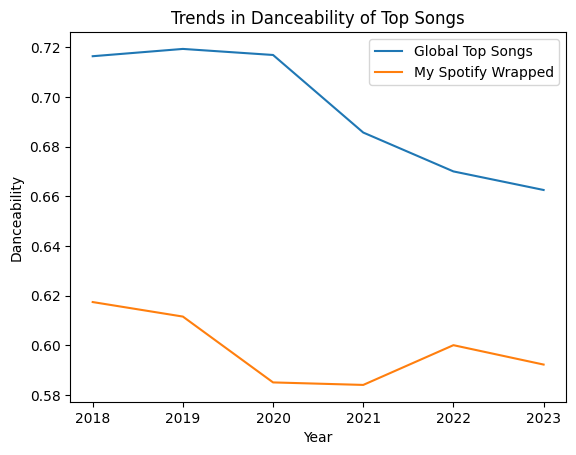

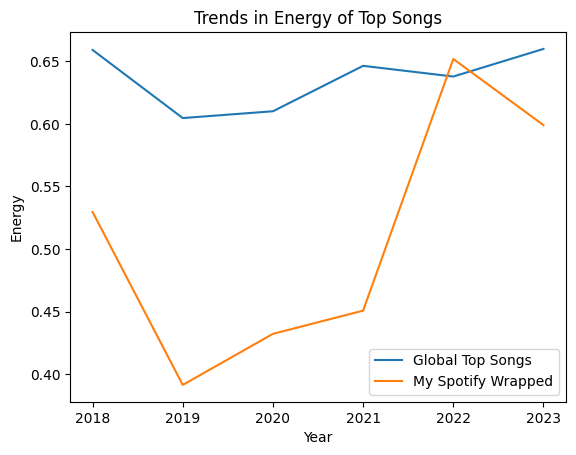

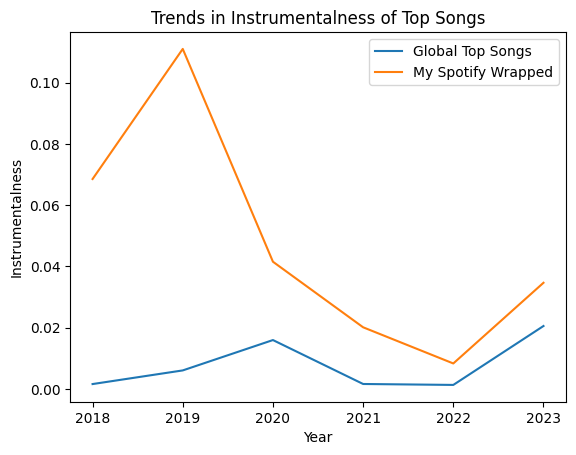

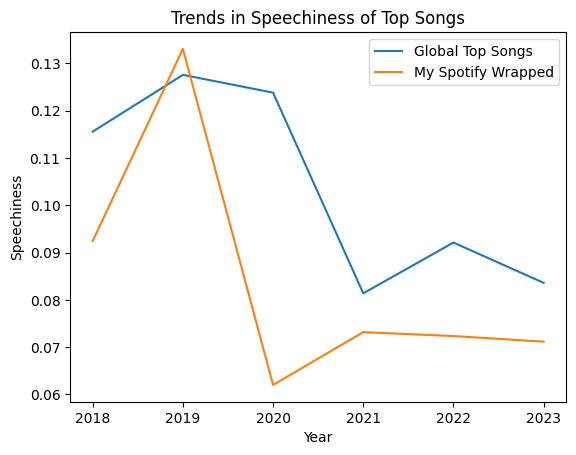

In [144]:
plt.plot(trend_avg_df['year'], trend_avg_df['danceability'], label='Global Top Songs')
plt.plot(wrapped_avg_df['year'], wrapped_avg_df['danceability'], label='My Spotify Wrapped')
plt.title('Trends in Danceability of Top Songs')
plt.xlabel('Year')
plt.ylabel('Danceability')
plt.legend()
plt.show()

plt.plot(trend_avg_df['year'], trend_avg_df['energy'], label='Global Top Songs')
plt.plot(wrapped_avg_df['year'], wrapped_avg_df['energy'], label='My Spotify Wrapped')
plt.title('Trends in Energy of Top Songs')
plt.xlabel('Year')
plt.ylabel('Energy')
plt.legend()
plt.show()

plt.plot(trend_avg_df['year'], trend_avg_df['instrumentalness'], label='Global Top Songs')
plt.plot(wrapped_avg_df['year'], wrapped_avg_df['instrumentalness'], label='My Spotify Wrapped')
plt.title('Trends in Instrumentalness of Top Songs')
plt.xlabel('Year')
plt.ylabel('Instrumentalness')
plt.legend()
plt.show()

plt.plot(trend_avg_df['year'], trend_avg_df['speechiness'], label='Global Top Songs')
plt.plot(wrapped_avg_df['year'], wrapped_avg_df['speechiness'], label='My Spotify Wrapped')
plt.title('Trends in Speechiness of Top Songs')
plt.xlabel('Year')
plt.ylabel('Speechiness')
plt.legend()
plt.show()

Change in all audio features for personal top streamed tracks over time
- Audio features: acousticness, danceability, energy, instrumentalness, liveness, speechiness, valence

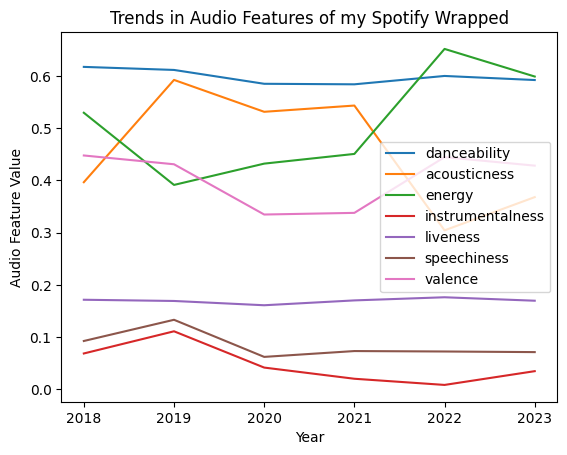

In [24]:
plt.plot(wrapped_avg_df['year'], wrapped_avg_df['danceability'], label='danceability')
plt.plot(wrapped_avg_df['year'], wrapped_avg_df['acousticness'], label='acousticness')
plt.plot(wrapped_avg_df['year'], wrapped_avg_df['energy'], label='energy')
plt.plot(wrapped_avg_df['year'], wrapped_avg_df['instrumentalness'], label='instrumentalness')
plt.plot(wrapped_avg_df['year'], wrapped_avg_df['liveness'], label='liveness')
plt.plot(wrapped_avg_df['year'], wrapped_avg_df['speechiness'], label='speechiness')
plt.plot(wrapped_avg_df['year'], wrapped_avg_df['valence'], label='valence')
plt.title('Trends in Audio Features of my Spotify Wrapped')
plt.xlabel('Year')
plt.ylabel('Audio Feature Value')
plt.legend()
plt.show()

### Feature selection:
Find audio features most closely related to personal highest streaming songs:
- Rank songs by index

In [137]:
# Use top 600 songs from past 6 months
user_track_df['idx'] = range(1,601)
user_track_df.head(10)

,track_id,name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,idx,group
0,136oL23K6A6g4PvptBWcS7,"Youth (YUNHO, MINGI)",ATEEZ,0.555,0.594,5,-5.343,0,0.1090,0.0287,0,0.2470,0.529,169.966,209360,4,1,0
1,2wj2Mh7Zmp036eH1aY6nAW,Turbulence,ATEEZ,0.462,0.826,4,-5.584,1,0.0718,0.1070,0,0.1790,0.615,169.980,199586,4,2,0
2,0fmdJr4UEfmqFCGFswAJPe,Not Too Late,ATEEZ,0.684,0.475,8,-7.646,1,0.0350,0.3080,0.000006,0.1510,0.495,94.039,214104,4,3,0
3,52PCrf2tqml44bWLNT58hF,MIST,ATEEZ,0.565,0.831,8,-2.758,1,0.0374,0.0818,0,0.1300,0.361,127.992,199027,4,4,0
4,7hWW1JxF5ArjPgAsGlwSuz,Silver Light,ATEEZ,0.695,0.828,2,-5.329,1,0.0506,0.0176,0.000001,0.0953,0.363,100.003,230477,4,5,0
5,77KnJc8o5G1eKVwX5ywMeZ,Mind Over Matter (Reprise),Young the Giant,0.393,0.487,0,-6.348,1,0.0337,0.2290,0,0.1280,0.300,151.958,230867,4,6,0
6,7yZD4AVfQtAZD4cG8eRnPk,DIE 4 YOU,DEAN,0.411,0.359,6,-9.928,0,0.0592,0.8020,0.000012,0.1040,0.277,82.631,194046,4,7,0
7,5vJr5hBQv8MqgBHOiaMvZA,Everything (JONGHO),ATEEZ,0.636,0.475,3,-6.767,1,0.0401,0.5600,0,0.0831,0.168,121.938,226892,4,8,0
8,4vk0If3wzFnqTsfn21HER7,Dreamy Day,ATEEZ,0.711,0.778,4,-5.847,1,0.0408,0.1460,0,0.0851,0.754,99.953,206645,4,9,0
9,2J8tamzlBEX2DWLx9ASTvS,AURORA,ATEEZ,0.696,0.775,8,-5.080,1,0.0290,0.0334,0,0.0949,0.597,95.007,204360,4,10,0


- Check for potential interactions between features

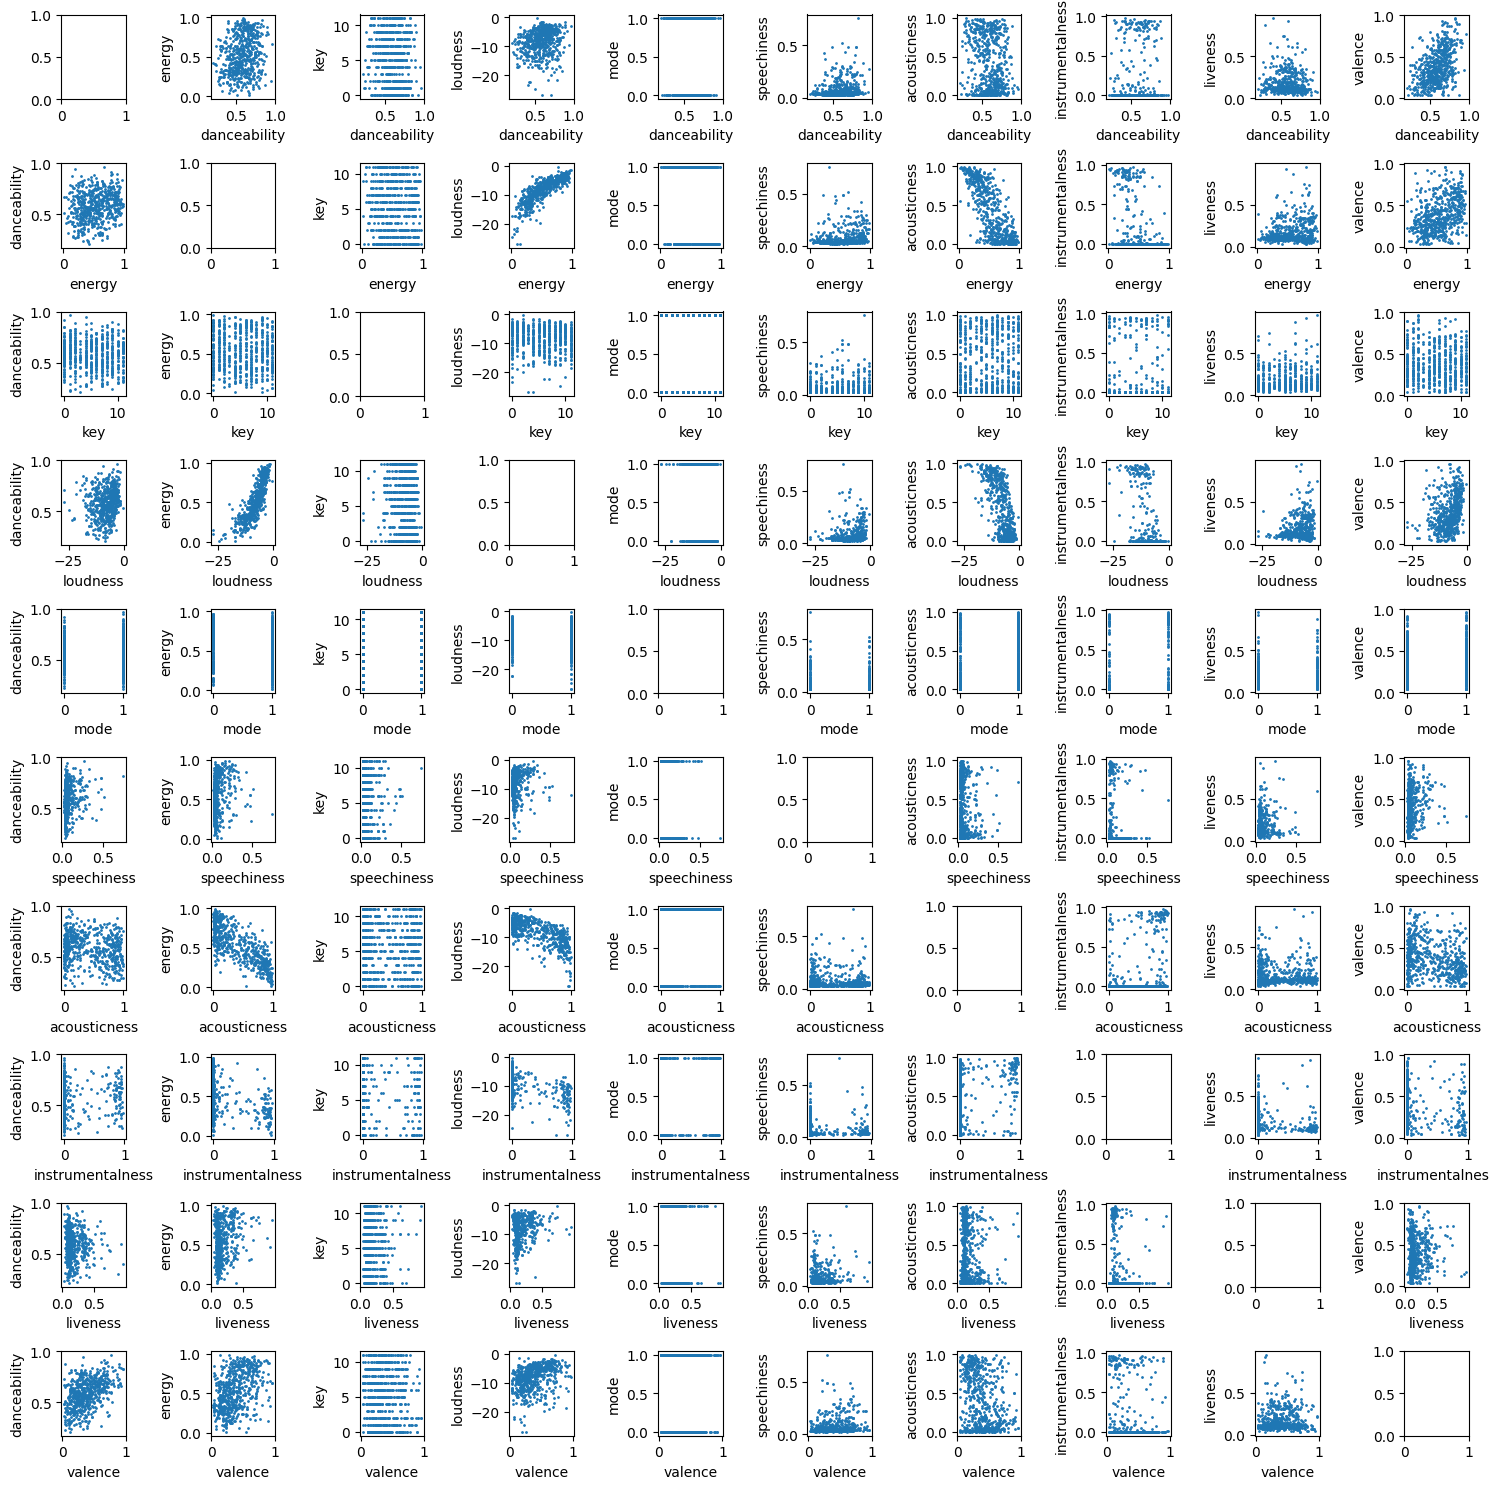

In [46]:
interactions = pd.DataFrame(user_track_df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']])

feature_names = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']

num_features = len(feature_names)
fig, axs = plt.subplots(num_features, num_features, figsize=(15, 15))

for i, feature1 in enumerate(feature_names):
    for j, feature2 in enumerate(feature_names):
        if i != j:
            axs[i, j].scatter(interactions[feature1], interactions[feature2], s=1)
            axs[i, j].set_xlabel(feature1)
            axs[i, j].set_ylabel(feature2)

plt.tight_layout()
plt.show()


- Appending all interaction terms to the dataset

In [127]:
x = user_track_df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']]
y = user_track_df['idx']

interaction_terms = pd.DataFrame()
for i, feature1 in enumerate(feature_names):
    for j, feature2 in enumerate(feature_names):
        if i != j:
            col = feature1 + ' * ' + feature2
            curr = user_track_df[feature1] * user_track_df[feature2]
            term = pd.DataFrame(curr, index=list(range(0,600)), columns=[col])
            interaction_terms = pd.concat([interaction_terms, term], axis=1)


# Combine original features with interaction terms
x_combined = pd.concat([x, interaction_terms, user_track_df['idx']], axis=1)

# Remove cols 56 - 101 (duplicates)
x_combined.drop(x_combined.iloc[:, 55:100], inplace=True, axis=1)

x_combined = x_combined.dropna(how='any',axis=0) 
y = x_combined['idx']
x_combined

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,mode * danceability,mode * energy,mode * key,mode * loudness,mode * speechiness,mode * acousticness,mode * instrumentalness,mode * liveness,mode * valence,idx
0,0.555,0.594,5,-5.343,0,0.1090,0.02870,0,0.2470,0.529,...,0.0,0.0,0,-0.0,0.0,0.0,0,0.0,0.0,1
1,0.462,0.826,4,-5.584,1,0.0718,0.10700,0,0.1790,0.615,...,0.462,0.826,4,-5.584,0.0718,0.107,0,0.179,0.615,2
2,0.684,0.475,8,-7.646,1,0.0350,0.30800,0.000006,0.1510,0.495,...,0.684,0.475,8,-7.646,0.035,0.308,0.000006,0.151,0.495,3
3,0.565,0.831,8,-2.758,1,0.0374,0.08180,0,0.1300,0.361,...,0.565,0.831,8,-2.758,0.0374,0.0818,0,0.13,0.361,4
4,0.695,0.828,2,-5.329,1,0.0506,0.01760,0.000001,0.0953,0.363,...,0.695,0.828,2,-5.329,0.0506,0.0176,0.000001,0.0953,0.363,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.390,0.477,9,-6.945,0,0.1700,0.86100,0.0945,0.5010,0.242,...,0.0,0.0,0,-0.0,0.0,0.0,0.0,0.0,0.0,596
596,0.498,0.353,6,-11.109,1,0.0620,0.88500,0.916,0.1120,0.791,...,0.498,0.353,6,-11.109,0.062,0.885,0.916,0.112,0.791,597
597,0.645,0.243,7,-16.029,1,0.0306,0.87400,0.864,0.1360,0.483,...,0.645,0.243,7,-16.029,0.0306,0.874,0.864,0.136,0.483,598
598,0.444,0.845,3,-4.859,0,0.1110,0.00748,0.141,0.1150,0.445,...,0.0,0.0,0,-0.0,0.0,0.0,0.0,0.0,0.0,599


- Determine variable significance with ANOVA F_regression & p-values

In [130]:
# Perform feature selection
selector = SelectKBest(score_func=f_regression, k=10)
X_selected = selector.fit_transform(x_combined, y)

# Get selected feature indices
selected_feature_indices = selector.get_support(indices=True)

selected_features = x_combined.iloc[:, selected_feature_indices]
selected_features

#print(selected_features.columns.tolist())

,loudness,instrumentalness,danceability * loudness,danceability * instrumentalness,energy * instrumentalness,key * instrumentalness,loudness * danceability,loudness * instrumentalness,mode * instrumentalness,idx
0,-5.343,0,-2.965365,0.0,0.0,0,-2.965365,-0.0,0,1
1,-5.584,0,-2.579808,0.0,0.0,0,-2.579808,-0.0,0,2
2,-7.646,0.000006,-5.229864,0.000004,0.000003,0.000051,-5.229864,-0.000049,0.000006,3
3,-2.758,0,-1.558270,0.0,0.0,0,-1.558270,-0.0,0,4
4,-5.329,0.000001,-3.703655,0.000001,0.000001,0.000002,-3.703655,-0.000006,0.000001,5
...,...,...,...,...,...,...,...,...,...,...
595,-6.945,0.0945,-2.708550,0.036855,0.045076,0.8505,-2.708550,-0.656303,0.0,596
596,-11.109,0.916,-5.532282,0.456168,0.323348,5.496,-5.532282,-10.175844,0.916,597
597,-16.029,0.864,-10.338705,0.55728,0.209952,6.048,-10.338705,-13.849056,0.864,598
598,-4.859,0.141,-2.157396,0.062604,0.119145,0.423,-2.157396,-0.685119,0.0,599


- The most significant variables and interaction terms as determined by the ANOVA model are as follows:
    - Loudness
    - Instrumentalness
    - Danceability * Loudness
    - Danceability * Instrumentalness
    - Energy * Instrumentalness
    - Key * Instrumentalness
    - Loudness * Instrumentalness
    - Mode * Instrumentalness
- To preserve hierarchy, the interaction terms with variables not selected by the model need to be removed or included along with both its features
    - Determined by p-values below:

In [142]:
# Get p-values 
p_values = selector.pvalues_
results = pd.DataFrame({'feature': x_combined.columns.tolist(), 'p-value': p_values})
results

,feature,p-value
0,danceability,2.222370e-01
1,energy,6.944397e-07
2,key,2.675254e-01
3,loudness,2.327021e-11
4,mode,1.664355e-01
5,speechiness,3.941335e-05
6,acousticness,1.118355e-05
7,instrumentalness,1.163886e-25
8,liveness,8.829577e-01
9,valence,3.950340e-01


- Danceability * Loudness and Danceability * Instrumentalness are two of the most significant terms, so I chose to include them along with the Danceability feature
- Mode and Key have relatively high p-values larger than 0.05, so I chose to omit the Key * Instrumentalness and Mode * Instrumentalness interaction terms
- Energy has a relatively significant p value, so I chose to include Energy and Energy * Instrumentalness in the model.
- The final features and interactions selected are:
    - Loudness
    - Instrumentalness
    - Danceability
    - Energy
    - Danceability * Loudness
    - Danceability * Instrumentalness
    - Energy * Instrumentalness
    - Loudness * Instrumentalness


### Optimize values of audio features for streaming time

- Fit a multiple linear regression
    - Response = Streaming Rank
    - Predictors:
        - Loudness
        - Instrumentalness
        - Danceability
        - Energy
        - Danceability * Loudness
        - Danceability * Instrumentalness
        - Energy * Instrumentalness
        - Loudness * Instrumentalness

In [138]:
X = x_combined[['loudness', 'instrumentalness', 'danceability', 'energy', 'danceability * loudness', 
                'danceability * instrumentalness', 'energy * instrumentalness', 'loudness * instrumentalness']]
y = x_combined['idx']

model = LinearRegression()
model.fit(X, y)

print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

Intercept: 245.621511858883
Coefficients: [ -2.4222276  -36.64170734   9.01771563   3.3231889    0.56495923
 398.56052054 -13.74768302  -1.93576862]


- Optimize
    - Adjust predictors to minimize streaming rank using regression function

In [139]:
def response_function(x):
    return model.intercept_ + model.coef_[0]*x[0] + model.coef_[1]*x[1] + model.coef_[2]*x[2] 
+ model.coef_[3]*x[3] + model.coef_[4]*x[4] + model.coef_[5]*x[5] + model.coef_[6]*x[6] + model.coef_[7]*x[7]

bounds = [(-60,0),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(-60,0)]

initial = np.array([0,0,0,0,0,0,0,0])

result = minimize(response_function, initial, method='SLSQP', bounds=bounds)

print("Optimal values for predictors:", result.x)
print("Minimum response value:", result.fun)

optimal_features = result.x

Optimal values for predictors: [ 0.00000000e+00  9.99999999e-01  1.40978784e-10  5.19544407e-11
  8.83371154e-12  6.23043661e-09  1.00000000e+00 -3.02622372e-11]
Minimum response value: 195.23212400448233


### Get recommendations:
New songs that fit my listening profile using the API function, selecting songs based on similarity in audio features & lyrics

In [150]:
# filter by genre, audio features
genres = ['pop', 'hip-hop', 'indie', 'k-pop']
result = spotify.recommendations(seed_genres=genres, limit=20, target_energy=optimal_features[0], 
                                 target_loudness=optimal_features[1], target_speechiness=optimal_features[2], 
                                 target_acousticness=optimal_features[3], target_instrumentalness=optimal_features[4])

recs = [['song name', 'artist']]

for track in result['tracks']:
    recs.append([track['name'], track['artists'][0]['name']])

recs

[['song name', 'artist'],
 ['Midnight - Single Version', 'Jessie Ware'],
 ["I Don't Care", '2NE1'],
 ['Teenage Fever', 'Drake'],
 ['Audi.', 'Smokepurpp'],
 ['Slow Hands', 'Niall Horan'],
 ['Your Best American Girl', 'Mitski'],
 ['Playaz Club', "Rappin' 4-Tay"],
 ['Fire', '2NE1'],
 ['Heathens', 'Twenty One Pilots'],
 ['Free', '6LACK'],
 ['Antidote', 'Travis Scott'],
 ['Amnesia', '5 Seconds of Summer'],
 ['Loyal', 'Chris Brown'],
 ['In The Club', '2NE1'],
 ['Nonstop', 'Drake'],
 ['No Rest', 'Lil Skies'],
 ['Wave of Mutilation (UK Surf)', 'Pixies'],
 ['Saw You In a Dream', 'The Japanese House'],
 ['Listening In', 'Dr. Dog'],
 ["Let's Go Party", '2NE1']]